Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Go to the dataset location

In [ ]:
%cd "/gdrive/My Drive/infogGan/"

/gdrive/My Drive/infogGan


In [ ]:
%ls

 img_align_celeba_50000.npz        'with cont(10) old'/
'our old model'/                   'with cont(20)'/
'with categ(2)'/                   'with cont(30) latent space 150'/
'with cont(10) latent space 150'/  'with cont(5) latent space 100'/
'with cont(10) new'/


# Training the model

Loading libs

In [ ]:
from numpy import load
from numpy import savez_compressed
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy import linspace
from numpy import mean
from numpy import expand_dims
from numpy import vstack
from numpy import hstack

from numpy.random import randn
from numpy.random import randint

#from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.initializers import RandomNormal

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation

from matplotlib import pyplot

import datetime, os

from math import sqrt

Define the standalone discriminator and q models

In [ ]:
# old descriminator
def define_discriminator(n_con, in_shape=(80,80,3)):
  #######################################################""
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 40x40
	d = Conv2D(16, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# downsample to 20x20
	d = Conv2D(32, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = LeakyReLU(alpha=0.2)(d)
	#d = BatchNormalization()(d)
	# downsample to 10x10
	d = Conv2D(64, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = LeakyReLU(alpha=0.2)(d)
	#d = BatchNormalization()(d)
	# downsample to 5x5
	d = Conv2D(128, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = LeakyReLU(alpha=0.2)(d)
	#d = BatchNormalization()(d)
	# normal
	d = Conv2D(256, (5,5), padding='same', kernel_initializer=init)(d)
	d = LeakyReLU(alpha=0.1)(d)
	#d = BatchNormalization()(d)
	# flatten feature maps
	d = Flatten()(d)
	# real/fake output
	out_classifier = Dense(1, activation='sigmoid')(d)
	# define d model
	d_model = Model(in_image, out_classifier)
	# compile d model
	d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
 
  ############################################################################

	# create q model layers
	q = Dense(128)(d)
	#q = BatchNormalization()(q)
	q = LeakyReLU(alpha=0.1)(q)
	# q model output
	out_codes = Dense(n_con, activation='linear')(q)
	# define q model
	q_model = Model(in_image, out_codes)
 
	return d_model, q_model

In [ ]:
# discriminator source: https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/#comment-563217
def define_discriminator(n_con, in_shape=(80,80,3)):
  #######################################################""
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 40x40
	d = Conv2D(128, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# downsample to 20x20
	d = Conv2D(128, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = LeakyReLU(alpha=0.2)(d)
	#d = BatchNormalization()(d)
	# downsample to 10x10
	d = Conv2D(128, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = LeakyReLU(alpha=0.2)(d)
	#d = BatchNormalization()(d)
	# downsample to 5x5
	d = Conv2D(128, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = LeakyReLU(alpha=0.2)(d)
	#d = BatchNormalization()(d)
	# normal
	#d = Conv2D(256, (5,5), padding='same', kernel_initializer=init)(d)
	#d = LeakyReLU(alpha=0.1)(d)
	#d = BatchNormalization()(d)
	# flatten feature maps
	d = Flatten()(d)
	# real/fake output
	out_classifier = Dense(1, activation='sigmoid')(d)
	# define d model
	d_model = Model(in_image, out_classifier)
	# compile d model
	d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
 
  ############################################################################

	# create q model layers
	q = Dense(128)(d)
	#q = BatchNormalization()(q)
	q = LeakyReLU(alpha=0.1)(q)
	# q model output
	out_codes = Dense(n_con, activation='linear')(q)
	# define q model
	q_model = Model(in_image, out_codes)
 
	return d_model, q_model

Define the standalone generator model

In [ ]:
# old generator
def define_generator(gen_input_size):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image generator input
	in_lat = Input(shape=(gen_input_size,))
	# foundation for 5x5 image
	n_nodes = 256 * 5 * 5
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	#gen = BatchNormalization()(gen)
	gen = Reshape((5, 5, 256))(gen)
	# normal
	gen = Conv2D(256, (4,4), padding='same', kernel_initializer=init)(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	#gen = BatchNormalization()(gen)
	# upsample to 10x10
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	#gen = BatchNormalization()(gen)
	# upsample to 20x20
	gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	#gen = BatchNormalization()(gen)
	# upsample to 40x40
	gen = Conv2DTranspose(32, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	#gen = BatchNormalization()(gen)
	# upsample to 80x80
	gen = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	# tanh output
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model(in_lat, out_layer)
	return model

In [ ]:
# generator source: https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/#comment-563217
def define_generator(gen_input_size):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image generator input
	in_lat = Input(shape=(gen_input_size,))
	# foundation for 5x5 image
	n_nodes = 128 * 5 * 5
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	#gen = BatchNormalization()(gen)
	gen = Reshape((5, 5, 128))(gen)
	# normal
	gen = Conv2D(128, (4,4), padding='same', kernel_initializer=init)(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	#gen = BatchNormalization()(gen)
	# upsample to 10x10
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	#gen = BatchNormalization()(gen)
	# upsample to 20x20
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	#gen = BatchNormalization()(gen)
	# upsample to 40x40
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	#gen = BatchNormalization()(gen)
	# upsample to 80x80
	gen = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	# tanh output
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model(in_lat, out_layer)
	return model

Define the combined discriminator, generator and q network model

In [ ]:
def define_gan(g_model, d_model, q_model):
	# make weights in the discriminator (some shared with the q model) as not trainable
	d_model.trainable = False
	# connect g outputs to d inputs
	d_output = d_model(g_model.output)
	# connect g outputs to q inputs
	q_output = q_model(g_model.output)
	# define composite model
	model = Model(g_model.input, [d_output, q_output])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mse'], optimizer=opt)
	return model

Define functions

In [ ]:
# the basic function are explained repeatedly in all Dr Dr Jason Brownlee articles, and this is where we got them, and we modified them to fit the InfoGAN environment.  
# load images
def load_real_samples():
	# load the face dataset
	data = load('img_align_celeba_50000.npz')
	X = data['arr_0']
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_con, n_samples):
	# generate points in the latent space
	z_latent = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_latent = z_latent.reshape(n_samples, latent_dim)
	# generate continuous codes
	con_codes = randn(n_con * n_samples)
	# reshape continuous codes
	con_codes = con_codes.reshape(n_samples, n_con)
	# concatenate latent points and control codes
	z_input = hstack((z_latent, con_codes))
	return [z_input, con_codes]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_con, n_samples):
	# generate points in latent space and control codes
	z_input, _ = generate_latent_points(latent_dim, n_con, n_samples)
	# predict outputs
	images = generator.predict(z_input)
	# create class labels
	y = zeros((n_samples, 1))
	return images, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, gan_model, latent_dim, n_con, n=10):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_con, n*n)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(n*n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i])
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save(filename2)
	# save the gan model
	filename3 = 'gan_model_%04d.h5' % (step+1)
	gan_model.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

Training function

In [ ]:
# the training function was explained in all all Dr Dr Jason Brownlee GAN articles, we modified it to balance the training process of InfoGAN model
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_con, n_epochs=100, n_batch=64):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	co = 0
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			if j % 2 == 0 or False:
				# get randomly selected 'real' samples
				X_real, y_real = generate_real_samples(dataset, half_batch)
				# update discriminator and q model weights
				d_loss1 = d_model.train_on_batch(X_real, y_real)
				# generate 'fake' examples
				X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_con, half_batch)
				# update discriminator model weights
				d_loss2 = d_model.train_on_batch(X_fake, y_fake)

			# prepare points in latent space as input for the generator
			z_input, con_codes = generate_latent_points(latent_dim, n_con, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the g via the d and q error
			_,g_1,g_2 = gan_model.train_on_batch(z_input, [y_gan, con_codes])
			# summarize loss on this batch
			print('>[%d] %d, d[%.3f,%.3f], g[%.3f] q[%.3f]' % (i, j, d_loss1, d_loss2, g_1, g_2))
		# evaluate the model performance every 'epoch'
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, gan_model, latent_dim, n_con)
		#if (i+1) % (bat_per_epo * 10) == 0:
		#	co=co+1
		#	summarize_performance(i, g_model, gan_model, latent_dim, n_con)

Init vars

In [ ]:
# number of values for the categorical control code
n_con = 5
# size of the latent space
latent_dim = 100
# create the discriminator
d_model, q_model = define_discriminator(n_con)
# create the generator
gen_input_size = latent_dim + n_con
g_model = define_generator(gen_input_size)
# create the gan
gan_model = define_gan(g_model, d_model, q_model)
#gan_model.summary()
# load image data
dataset = load_real_samples()

Print models summary 

In [ ]:
#d_model.summary()
print("#########################################################################")
#q_model.summary()
print("#########################################################################")
#g_model.summary()
print("#########################################################################")
gan_model.summary()
print("#########################################################################")

train the model

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, n_con)

Streaming output truncated to the last 5000 lines.
>[26] 672, d[0.639,0.660], g[0.780] q[0.031]
>[26] 673, d[0.639,0.660], g[0.765] q[0.038]
>[26] 674, d[0.639,0.695], g[0.753] q[0.036]
>[26] 675, d[0.639,0.695], g[0.747] q[0.033]
>[26] 676, d[0.620,0.777], g[0.753] q[0.034]
>[26] 677, d[0.620,0.777], g[0.733] q[0.035]
>[26] 678, d[0.638,0.667], g[0.779] q[0.036]
>[26] 679, d[0.638,0.667], g[0.760] q[0.035]
>[26] 680, d[0.648,0.768], g[0.796] q[0.034]
>[26] 681, d[0.648,0.768], g[0.750] q[0.033]
>[26] 682, d[0.685,0.699], g[0.803] q[0.037]
>[26] 683, d[0.685,0.699], g[0.762] q[0.030]
>[26] 684, d[0.689,0.698], g[0.802] q[0.039]
>[26] 685, d[0.689,0.698], g[0.784] q[0.038]
>[26] 686, d[0.682,0.677], g[0.807] q[0.032]
>[26] 687, d[0.682,0.677], g[0.759] q[0.032]
>[26] 688, d[0.648,0.673], g[0.774] q[0.032]
>[26] 689, d[0.648,0.673], g[0.735] q[0.031]
>[26] 690, d[0.639,0.702], g[0.785] q[0.029]
>[26] 691, d[0.639,0.702], g[0.704] q[0.030]
>[26] 692, d[0.682,0.703], g[0.768] q[0.027]
>[26

KeyboardInterrupt: ignored

# Testing the model

In [ ]:
%cd "with cont(5) latent space 100"

/gdrive/My Drive/infogGan/with cont(5) latent space 100


defining functions
(variating the first control var)

In [ ]:
import time

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_con, n_samples):
	# generate points in the latent space
	z_latent = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_latent = z_latent.reshape(n_samples, latent_dim)
	# generate continuous codes
	con_codes = randn(n_con * n_samples)
	#con_codes = linspace(-1, 2, num=50)
	# reshape continuous codes
	con_codes = con_codes.reshape(n_samples, n_con)
	#con_codes = con_codes.reshape(25, n_con)
	#con_codes = asarray([ [i, i, i, i, i] for i in linspace(-1, 2, num=25)])
	# concatenate latent points and control codes
	z_input = hstack((z_latent, con_codes))
	return [z_input, con_codes]

# create and save a plot of generated images
def save_plot(examples, n_examples):
	# plot images
	for i in range(n_examples):
		# define subplot
		pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	pyplot.savefig(str(time.time()) + ".png")
	pyplot.show()
	pyplot.close()
 
 # create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	pyplot.savefig('generated_faces.png')
	pyplot.show()
	pyplot.close()
 
# create a plot of generated image
def plot_fig(example):
	pyplot.imshow(example)
	pyplot.savefig(str(time.time()) + ".png")
	pyplot.show()
	pyplot.close()

In [ ]:
%ls

gan_model_0010.h5    generated_plot_0010.png  model_0010.h5
gan_model_0020.h5    generated_plot_0020.png  model_0020.h5
gan_model_0030.h5    generated_plot_0030.png  model_0030.h5
gan_model_0040.h5    generated_plot_0040.png  model_0040.h5
gan_model_0050.h5    generated_plot_0050.png  model_0050.h5
gan_model_0060.h5    generated_plot_0060.png  model_0060.h5
gan_model_0070.h5    generated_plot_0070.png  model_0070.h5
gan_model_0080.h5    generated_plot_0080.png  model_0080.h5
gan_model_0090.h5    generated_plot_0090.png  model_0090.h5
generated_faces.png  latent_points.npz


Running the test (for your own safety dont change n_con and latent_dim)

In [ ]:
# load model
model = load_model('model_0090.h5')
#model = load_model('model_84330.h5')
# number of continuous control codes
n_con = 5
# size of the latent space
latent_dim = 100
# number of examples to generate
n_samples = 25

**Ploting random faces**

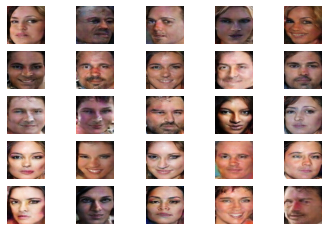

In [ ]:
# generate points in latent space and control codes
z_input, _ = generate_latent_points(latent_dim, n_con, n_samples)
# predict outputs
X = model.predict(z_input)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, n_samples)
#plot_generated(X[1])

**uniform interpolation between two points**

In [ ]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

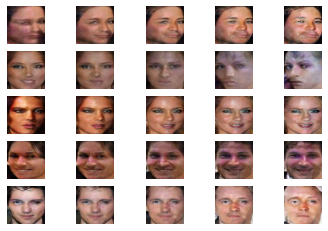

In [ ]:
n = 10
pts, _ = generate_latent_points(100, n_con, n)
# interpolate pairs
results = None
for i in range(0, n, 2):
	# interpolate points in latent space
	interpolated = interpolate_points(pts[i], pts[i+1], int(n/2))
	# generate images
	X = model.predict(interpolated)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	if results is None:
		results = X
	else:
		results = vstack((results, X))
# plot the result
plot_generated(results, int(n/2))

**spherical linear interpolation between two points**

In [ ]:
from numpy import arccos
from numpy import clip
from numpy import dot
from numpy import sin
from numpy.linalg import norm

# spherical linear interpolation (slerp)
def slerp(val, low, high):
	omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
	so = sin(omega)
	if so == 0:
		# L'Hopital's rule/LERP
		return (1.0-val) * low + val * high
	return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high

# uniform interpolation between two points in latent space
def s_interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = slerp(ratio, p1, p2)
		vectors.append(v)
	return asarray(vectors)

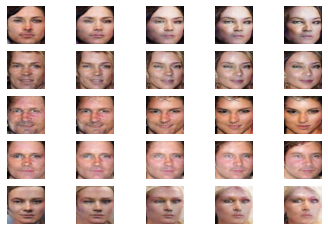

In [ ]:
n = 10
pts, _ = generate_latent_points(100, n_con, n)
# interpolate pairs
results = None
for i in range(0, n, 2):
	# interpolate points in latent space
	interpolated = s_interpolate_points(pts[i], pts[i+1], int(n/2))
	# generate images
	X = model.predict(interpolated)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	if results is None:
		results = X
	else:
		results = vstack((results, X))
# plot the result
plot_generated(results, int(n/2))

**Vector Arithmetic With Faces** 

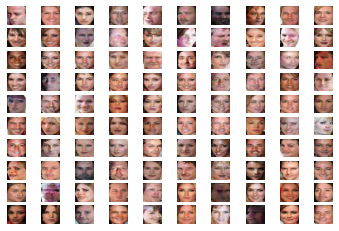

In [ ]:
# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	#zero_ix = [i-1 for i in ix]
	zero_ix = ix
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_detailed_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()
n = 100
latent_points, _ = generate_latent_points(100, n_con, n)
# save points
savez_compressed('latent_points.npz', latent_points)
# generate images
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# save plot
plot_generated(X, 10)

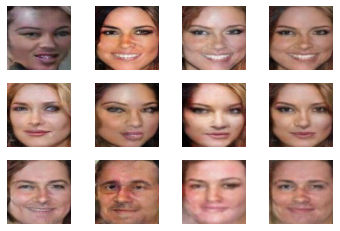

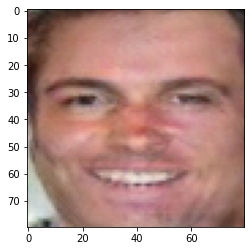

In [ ]:
# retrieve specific points
smiling_woman_ix = [4, 14, 31]
neutral_woman_ix = [0, 30, 97]
neutral_man_ix = [99, 96, 49]
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# generate images
images = model.predict(all_vectors)
# scale pixel values
images = (images + 1) / 2.0
plot_detailed_generated(images, 3, 4)
# smiling woman - neutral woman + neutral man = smiling man
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

### Testing the control variables

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_con, rest_val, n_samples):
	# generate points in the latent space
	z_latent = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_latent = z_latent.reshape(n_samples, latent_dim)
	# variate the control variables
	if(n_con == 1):
		con_codes = asarray([ [i, rest_val, rest_val, rest_val, rest_val] for i in linspace(-1, 2, num=25)])
	elif(n_con == 2):
		con_codes = asarray([ [rest_val, i, rest_val, rest_val, rest_val] for i in linspace(-1, 2, num=25)])
	elif(n_con == 3):
		con_codes = asarray([ [rest_val, rest_val, i, rest_val, rest_val] for i in linspace(-1, 2, num=25)])
	elif(n_con == 4):
		con_codes = asarray([ [rest_val, rest_val, rest_val, i, rest_val] for i in linspace(-1, 2, num=25)])
	elif(n_con == 5):
		con_codes = asarray([ [rest_val, rest_val, rest_val, rest_val, i] for i in linspace(-1, 2, num=25)])
	elif(n_con == 6):
		con_codes = asarray([ [rest_val, rest_val, rest_val, rest_val, rest_val] for i in linspace(-1, 2, num=25)])

	# concatenate latent points and control codes
	z_input = hstack((z_latent, con_codes))
	return z_input

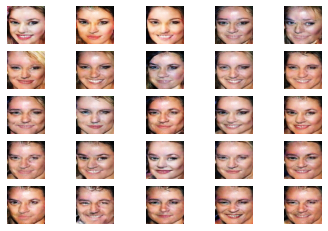

In [ ]:
control_var = 1
default_value = 2
z_input = generate_latent_points(latent_dim, control_var, default_value, n_samples)
# predict outputs
X = model.predict(z_input)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, n_samples)